In [21]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, os, random as rd

In [38]:
from scipy.cluster.hierarchy import dendrogram
from scipy import stats

In [36]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn import decomposition

In [37]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

def plot_dendrogram(Z, names):
    plt.figure(figsize=(10,25))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    plt.show()

# <p style='text-align:center'> Import des données </p>

In [2]:
data = pd.concat([pd.read_csv('cleaned_data/' + f) for f in os.listdir('cleaned_data')], axis = 0).reset_index(drop=True)

In [32]:
# data.info()

In [3]:
column_nutrition=['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g','sodium_100g','fruits-vegetables-nuts-estimate-from-ingredients_100g','nutrition-score-fr_100g','energy_kcal_100g']
data_nutrition = data[column_nutrition]

# <p style='text-align:center;'> Analyse Univariée </p>

## Analyse de la variable pnns_groups_2

La variable pnns_group_2 est essentielle au projet d’application. Nous allons étudier le renseignement de cette variable car nous devons garantir sa complétion.

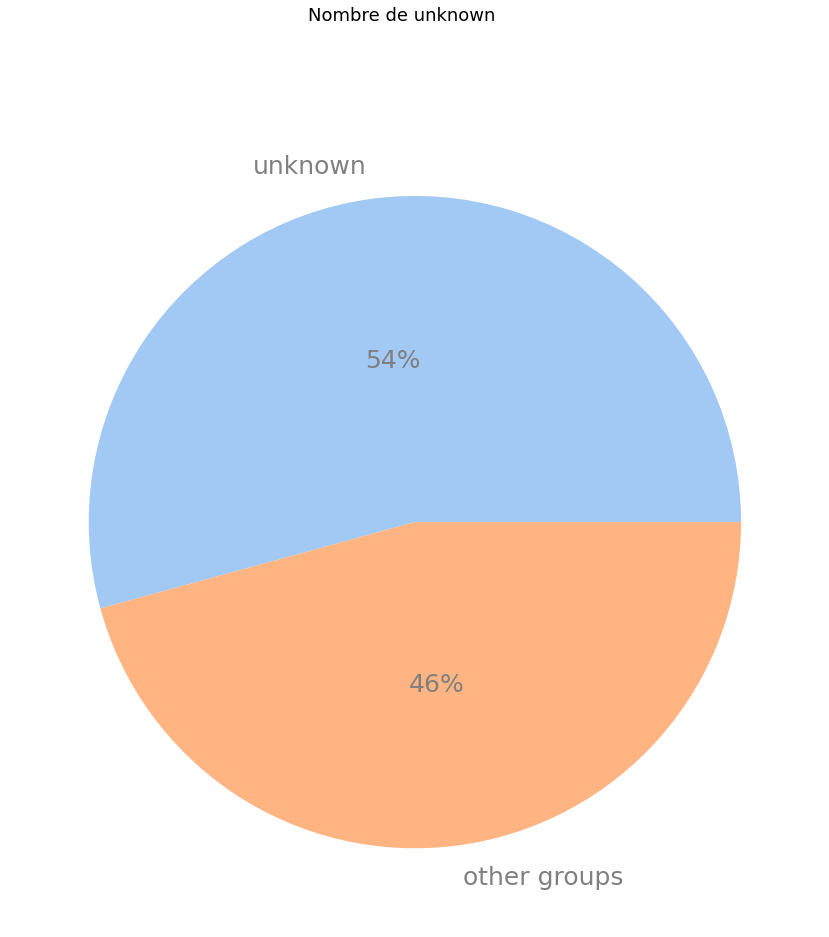

In [4]:
f, ax = plt.subplots(figsize=(15,15))
group_order=data['pnns_groups_2'].apply(lambda x : 'other groups' if x!='unknown' else x).value_counts().index
values=data['pnns_groups_2'].apply(lambda x : 'other groups' if x!='unknown' else x).value_counts().values
colors = sns.color_palette('pastel')[0:2]
plt.pie(x=values,labels=group_order,autopct='%.0f%%',pctdistance=0.5,colors=colors,textprops={'color':'grey','size':25})
f.suptitle('Nombre de unknown',size=18)
plt.show()

On remarque qu’une grande majorité de produits appartient à la classe unknown. Pour la compléter, on opte pour un KNNClassifier qui va classer les produits à partir de leur distribution de variables nutritionnelles on se basant sur l’approche des plus proches voisins.

In [5]:
# data[data['pnns_groups_2']!='unknown'].pnns_groups_2.value_counts()

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

y = data[data['pnns_groups_2']!='unknown'].pnns_groups_2
X = data[column_nutrition[:-2]].iloc[y.index].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train) 
 
# KNeighborsClassifier(...)
data_inputed_non_scaled_pnns=data.copy()
data_inputed_non_scaled_pnns["predicted_pnns"]=neigh.predict(data[column_nutrition[:-2]])

Après la classification, on obtient cette répartition de produits.

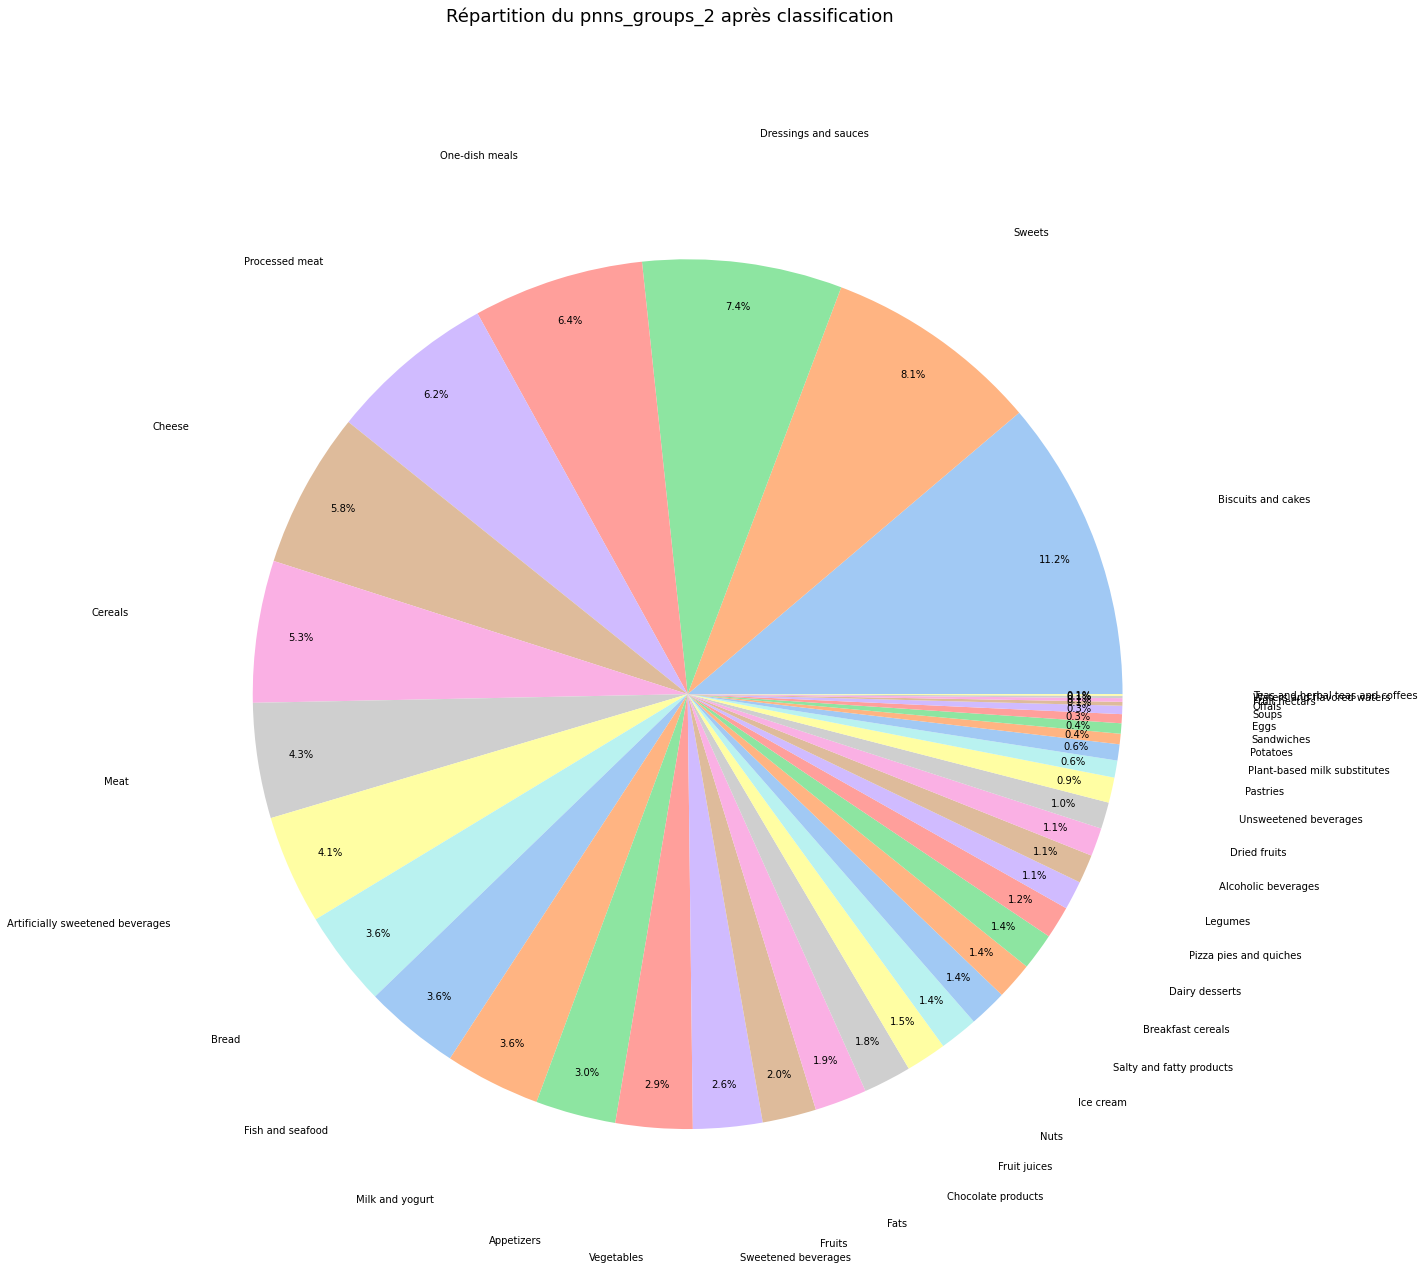

In [7]:
f, ax = plt.subplots(figsize=(20,20))
group_order=data_inputed_non_scaled_pnns['predicted_pnns'].value_counts().index
values=data_inputed_non_scaled_pnns['predicted_pnns'].value_counts().values
colors = sns.color_palette('pastel')[0:30]
plt.pie(x=values,labels=group_order,autopct='%.1f%%',pctdistance=0.9,colors=colors,labeldistance=1.3)
f.suptitle('Répartition du pnns_groups_2 après classification',size=18)
plt.show()

In [8]:
print(neigh.score(X_train,y_train))

0.8084197841349681


In [9]:
print(neigh.score(X_test,y_test))

0.6917435037720033


Le modèle affiche une fiabilité de 80% sur les données d’entrainement et de 67% sur les données de test.
Les performances sont plutôt satisfaisantes compte tenu de la ressemblance de certaines classes de pnns_groups_2 (sweets et pastries par exemple)

## Analyse de la variable nutriscore_grade

Cette variable va nous permettre d'indiquer à l’utilisateur les qualités nutritionnelles des produits.Elle sera utilisée en complément de la variable nutriscore (numérique)

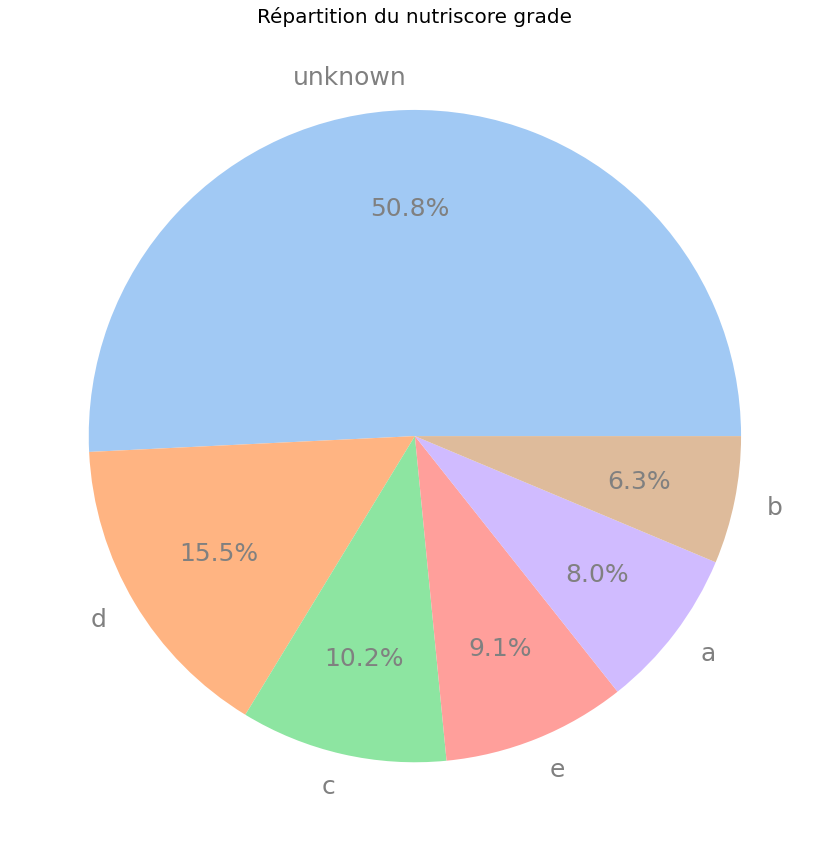

In [10]:
f, ax = plt.subplots(figsize=(15,15))
group_order=data['nutriscore_grade'].fillna('unknown').sort_values(ascending=True).value_counts().index
values=data['nutriscore_grade'].fillna('unknown').sort_values(ascending=True).value_counts().values
colors = sns.color_palette('pastel')[0:30]
plt.pie(x=values,labels=group_order,autopct='%.1f%%',pctdistance=0.7,colors=colors,labeldistance=1.1,textprops={'color':'grey','size':25})
ax.set_title('Répartition du nutriscore grade',size=20)
plt.show()

Pour les même raisons que pour le pnns_groups_2, on opte pour un KNNClassifier pour la compléter.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

y = data.nutriscore_grade.dropna()
X = data[column_nutrition[:-2]].copy()
X = X.iloc[y.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train) 
 
# KNeighborsClassifier(...)
data_inputed_grade=data[column_nutrition[:-2]].copy()
data_inputed_grade["predicted_nutriscore_grade"]=neigh.predict(data[column_nutrition[:-2]])

Après la classification, on obtient cette répartition de nutriscore.

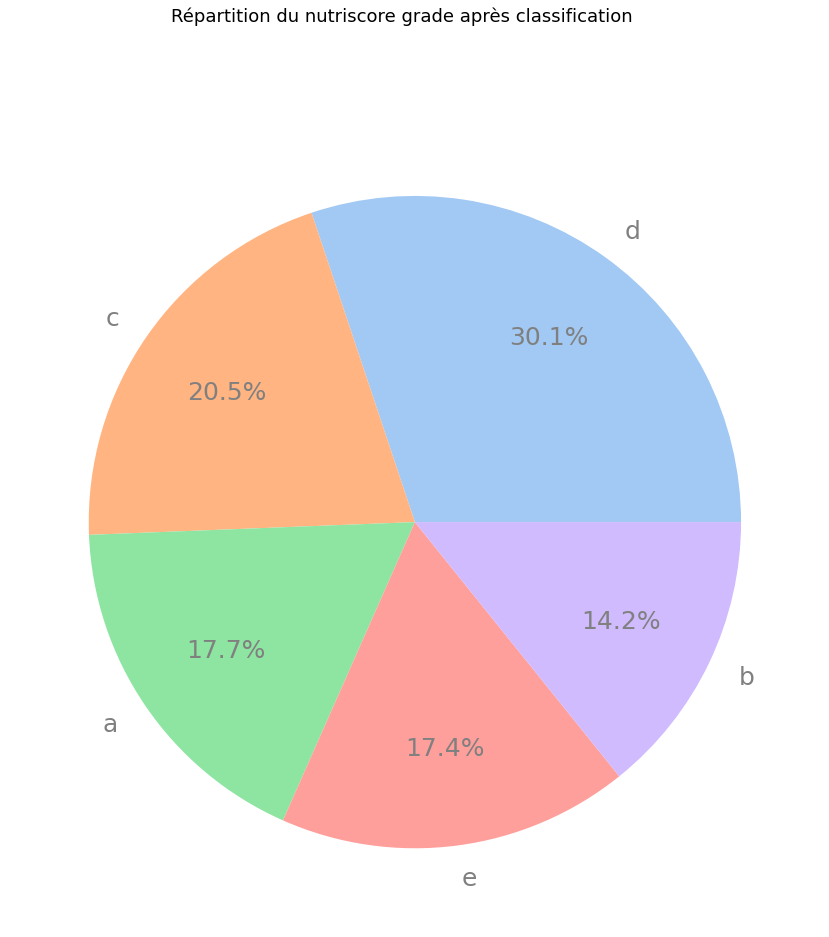

In [12]:
f, ax = plt.subplots(figsize=(15,15))
group_order=data_inputed_grade['predicted_nutriscore_grade'].sort_values(ascending=True).value_counts().index
values=data_inputed_grade['predicted_nutriscore_grade'].sort_values(ascending=True).value_counts().values
colors = sns.color_palette('pastel')[0:30]
plt.pie(x=values,labels=group_order,autopct='%.1f%%',pctdistance=0.7,colors=colors,labeldistance=1.1,textprops={'color':'grey','size':25})
f.suptitle('Répartition du nutriscore grade après classification',size=18)
plt.show()

In [13]:
print(neigh.score(X_train,y_train))

0.8522854500316409


In [14]:
print(neigh.score(X_test,y_test))

0.732768691588785


Le modèle affiche une fiabilité de 84% sur les données d’entrainement et de 72% sur les données de test.

# <p style='text-align:center;'> Analyse Bivariée </p>

## Analyse des variables nutritionnelles

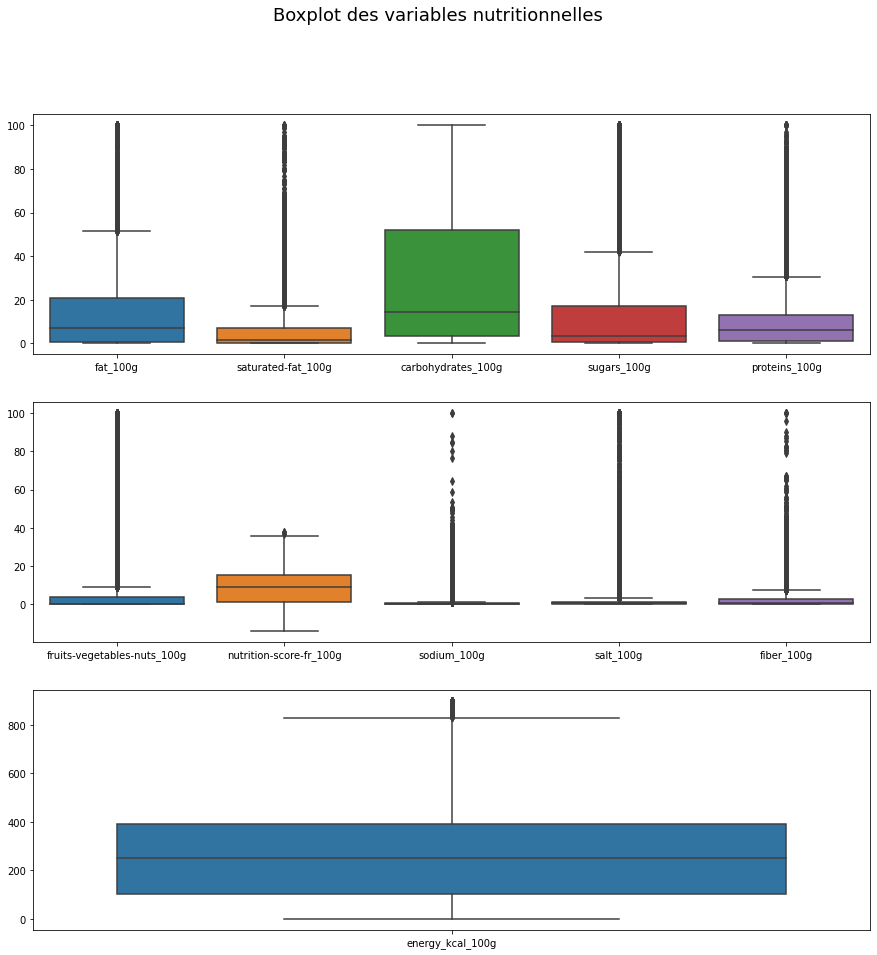

In [15]:
#Boxplots
fig,axs=plt.subplots(3,1,figsize=(15,15))
sns.boxplot(ax=axs[0],data=data_nutrition[['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g']])
sns.boxplot(ax=axs[1],data=data_nutrition.rename({'fruits-vegetables-nuts-estimate-from-ingredients_100g':'fruits-vegetables-nuts_100g'},axis=1)[['fruits-vegetables-nuts_100g','nutrition-score-fr_100g', 'sodium_100g','salt_100g','fiber_100g']])
fig.suptitle('Boxplot des variables nutritionnelles',size=18)
sns.boxplot(ax=axs[2],data=data_nutrition.energy_kcal_100g.to_frame())
plt.show()

Ce graphique permet de se rassurer quant à l'absence de valeurs aberrantes. Les valeurs médianes sont assez basses.

<AxesSubplot:ylabel='Count'>

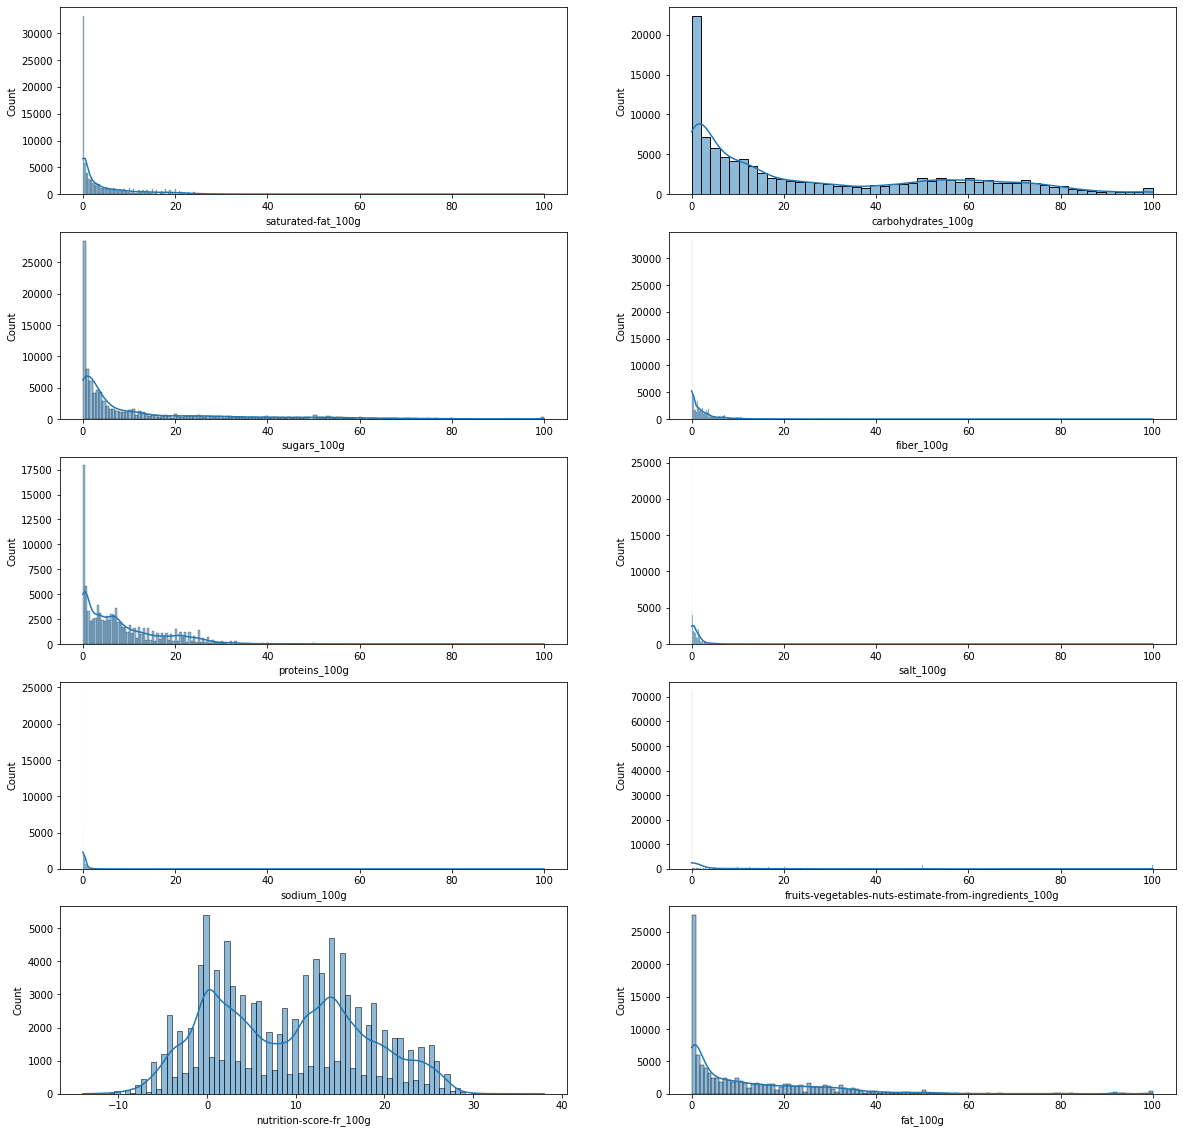

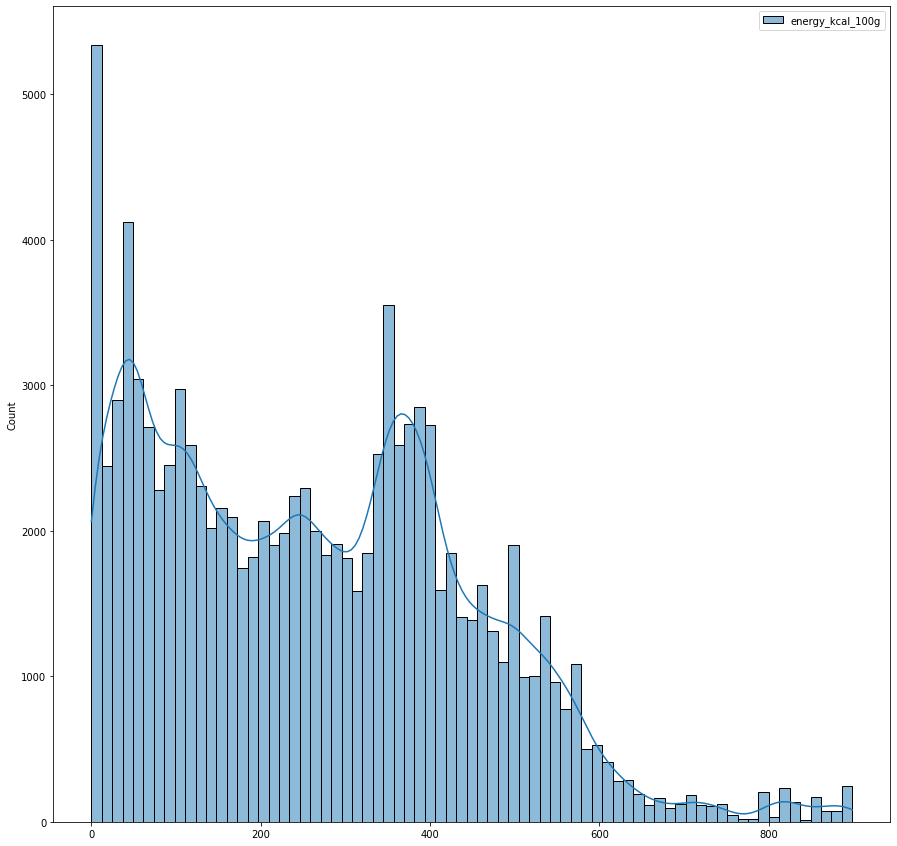

In [16]:
#Histogrammes
fig,axs=plt.subplots(5,2,figsize=(20,20))
p={0:(0,0),1:(0,1),2:(1,0),3:(1,1),4:(2,0),5:(2,1),6:(3,0),7:(3,1)}
for i in range(0,data_nutrition.columns[0:-1].shape[0]):
    if i%2==0:
        sns.histplot(ax=axs[(i//2-1,i%2+1)],data=data_nutrition[data_nutrition.columns[i]],kde=True)
    else:
        sns.histplot(ax=axs[(i//2,i%2-1)],data=data_nutrition[data_nutrition.columns[i]],kde=True)
fig,axs=plt.subplots(1,1,figsize=(15,15))
display(sns.histplot(ax=axs,data=data_nutrition['energy_kcal_100g'].to_frame(),kde=True))

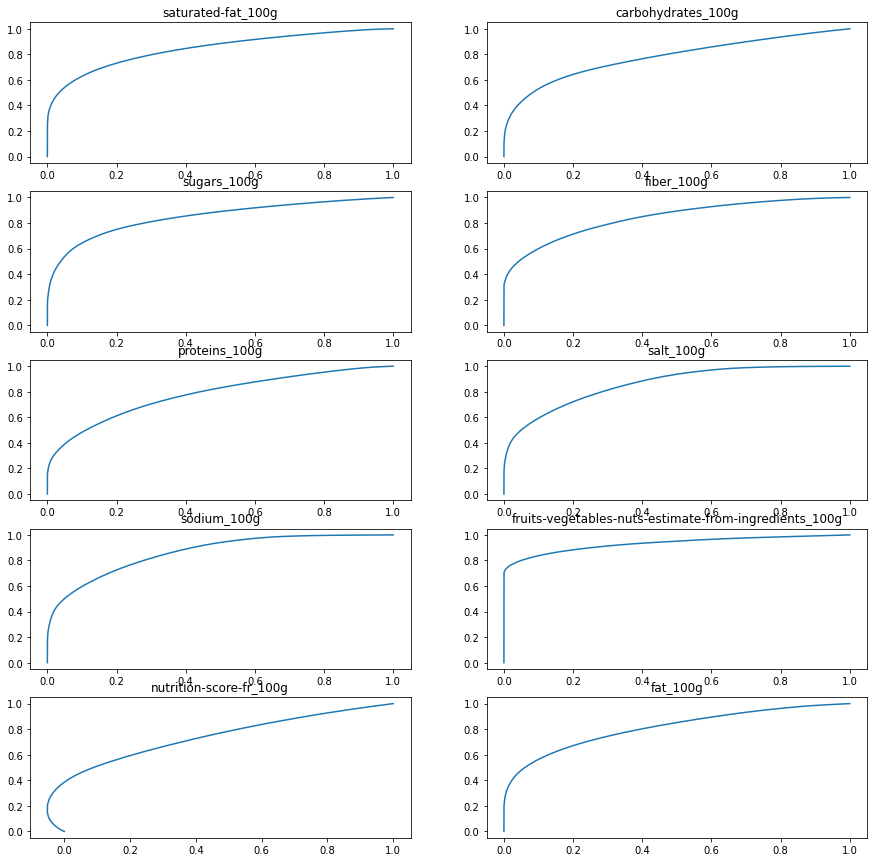

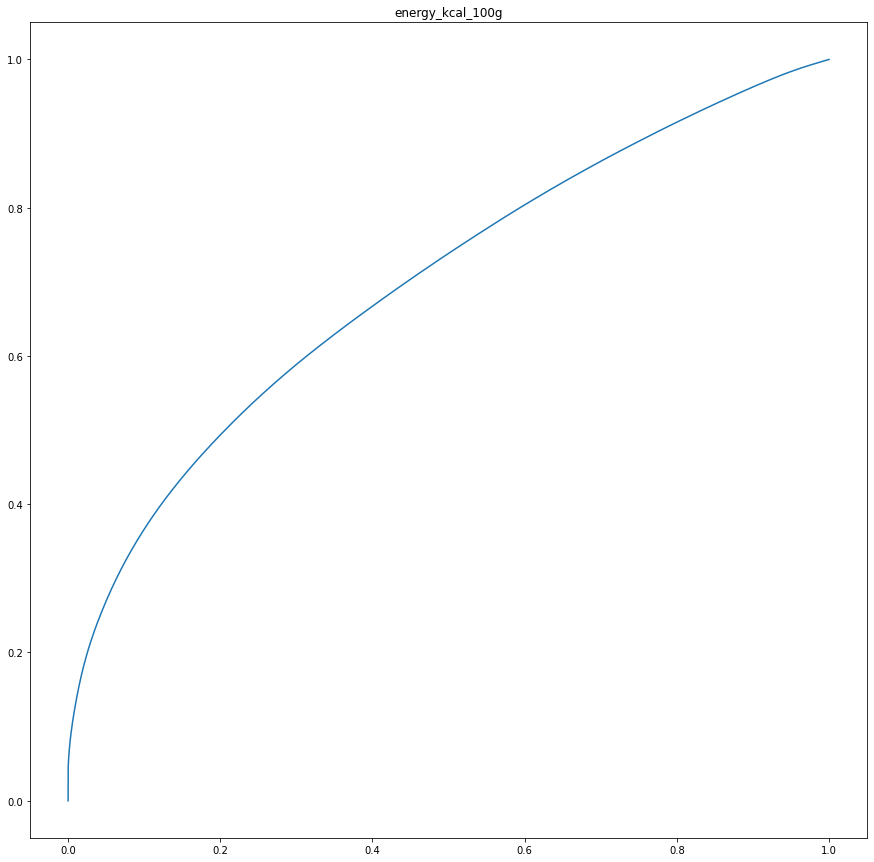

In [17]:
#Courbes de Lorrentz
data_nutrition_l=data_nutrition.dropna()
n=data_nutrition_l.shape[0]
p=data_nutrition_l.shape[1]
fig,axs=plt.subplots(5,2,figsize=(15,15))
for i in range(0,p-1):
    if i%2==0:
        col=data_nutrition_l.columns[i]
        axs[(i//2-1,i%2+1)].plot(np.append([0],np.cumsum(np.sort(data_nutrition_l[col].values))/(data_nutrition_l[col].values.sum())),np.linspace(0-1/n,1+1/n,n+1))
        axs[(i//2-1,i%2+1)].set_title(col)
    else:
        col=data_nutrition_l.columns[i]
        axs[(i//2,i%2-1)].plot(np.append([0],np.cumsum(np.sort(data_nutrition_l[col].values))/(data_nutrition_l[col].values.sum())),np.linspace(0-1/n,1+1/n,n+1))
        axs[(i//2,i%2-1)].set_title(col)
fig,axs=plt.subplots(1,1,figsize=(15,15))
axs.set_title('energy_kcal_100g')
display(plt.plot(np.append([0],np.cumsum(np.sort(data_nutrition_l['energy_kcal_100g'].values))/(data_nutrition_l['energy_kcal_100g'].values.sum())),np.linspace(0-1/n,1+1/n,n+1)))

On calcule les coefficients de Pearson que l’on regroupé dans la matrice de corrélation pour étudier les relations de linéarité entre les variables nutritionnelles.

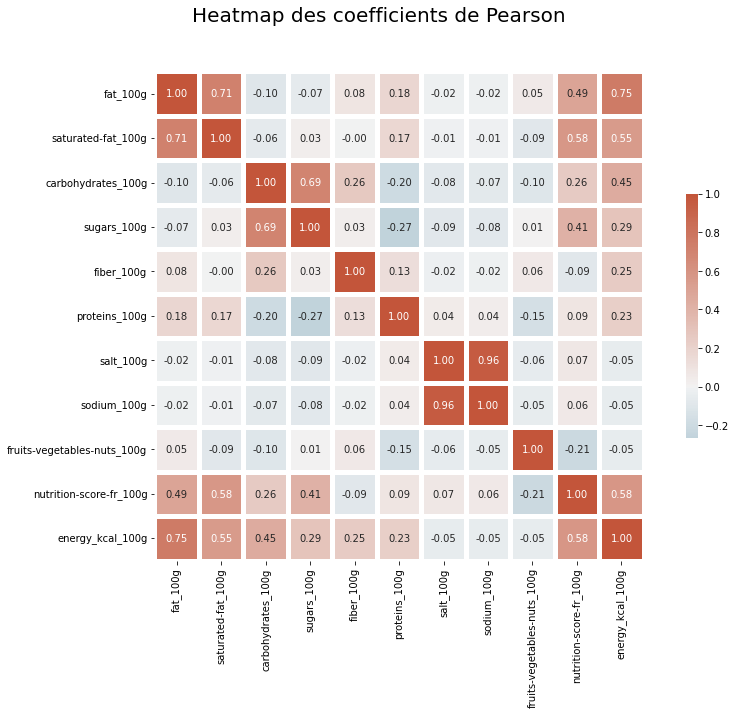

In [18]:
f, ax = plt.subplots(figsize=(15,9))
cmap=sns.diverging_palette(230,20,as_cmap=True)
sns.heatmap(data_nutrition.rename({'fruits-vegetables-nuts-estimate-from-ingredients_100g':'fruits-vegetables-nuts_100g'},axis=1).corr(),annot=True, fmt='.2f',cmap=cmap,vmax=1,center=0,square=True,linewidths=5,cbar_kws={"shrink":.5})
f.suptitle('Heatmap des coefficients de Pearson',size=20)
plt.show()

On constate globalement une absence de relation linéaire sauf une relation nette entre le sel et le sodium, et des relations plus modérées entre le gras et le gras saturés, entre l'energie et le nutriscore et entre le sucre et les glucides.

## Analyse du nutriscore en fonction des variables nutritionnelles

On constate que le nutriscore est une grandeur discrète qui des valeurs entières entre -15 (A) et 30 (E)

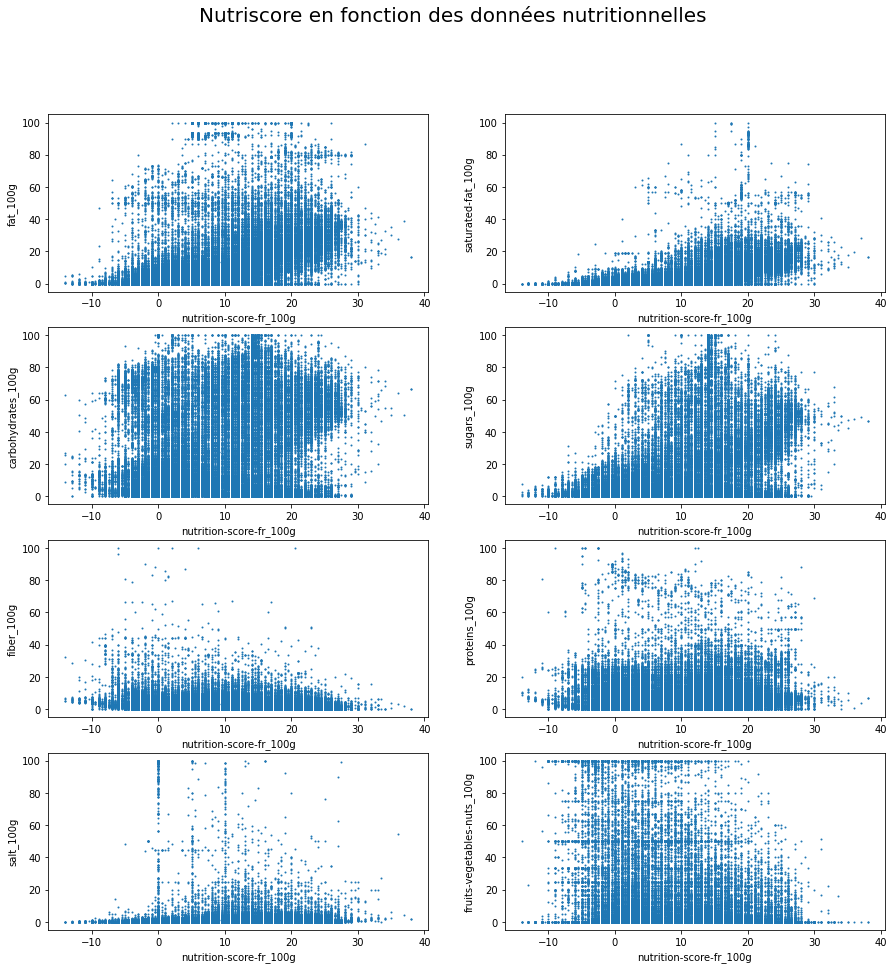

In [19]:
#Nutriscore en fonction des variables nutritionnelles
fig,axes=plt.subplots(4,2,figsize=(15,15))
axes[0,0].scatter(data_nutrition['nutrition-score-fr_100g'],data_nutrition["fat_100g"],s=1)
axes[0,0].set_xlabel('nutrition-score-fr_100g')
axes[0,0].set_ylabel("fat_100g")

axes[0,1].scatter(data_nutrition['nutrition-score-fr_100g'],data_nutrition["saturated-fat_100g"],s=1)
axes[0,1].set_xlabel('nutrition-score-fr_100g')
axes[0,1].set_ylabel("saturated-fat_100g")

axes[1,0].scatter(data_nutrition['nutrition-score-fr_100g'],data_nutrition['carbohydrates_100g'],s=1)
axes[1,0].set_xlabel('nutrition-score-fr_100g')
axes[1,0].set_ylabel('carbohydrates_100g')

axes[1,1].scatter(data_nutrition['nutrition-score-fr_100g'],data_nutrition['sugars_100g'],s=1)
axes[1,1].set_xlabel('nutrition-score-fr_100g')
axes[1,1].set_ylabel('sugars_100g')

axes[2,0].scatter(data_nutrition['nutrition-score-fr_100g'],data_nutrition['fiber_100g'],s=1)
axes[2,0].set_xlabel('nutrition-score-fr_100g')
axes[2,0].set_ylabel('fiber_100g')

axes[2,1].scatter(data_nutrition['nutrition-score-fr_100g'],data_nutrition['proteins_100g'],s=1)
axes[2,1].set_xlabel('nutrition-score-fr_100g')
axes[2,1].set_ylabel('proteins_100g')

axes[3,0].scatter(data_nutrition['nutrition-score-fr_100g'],data_nutrition['salt_100g'],s=1)
axes[3,0].set_xlabel('nutrition-score-fr_100g')
axes[3,0].set_ylabel('salt_100g')

axes[3,1].scatter(data_nutrition['nutrition-score-fr_100g'],data_nutrition['fruits-vegetables-nuts-estimate-from-ingredients_100g'],s=1)
axes[3,1].set_xlabel('nutrition-score-fr_100g')
axes[3,1].set_ylabel('fruits-vegetables-nuts_100g')
fig.suptitle('Nutriscore en fonction des données nutritionnelles',size=20)
plt.show()

On isole 5 produits pris au hasard pour faciliter l'interprétation

[94975, 67163, 44115, 37138, 4799]


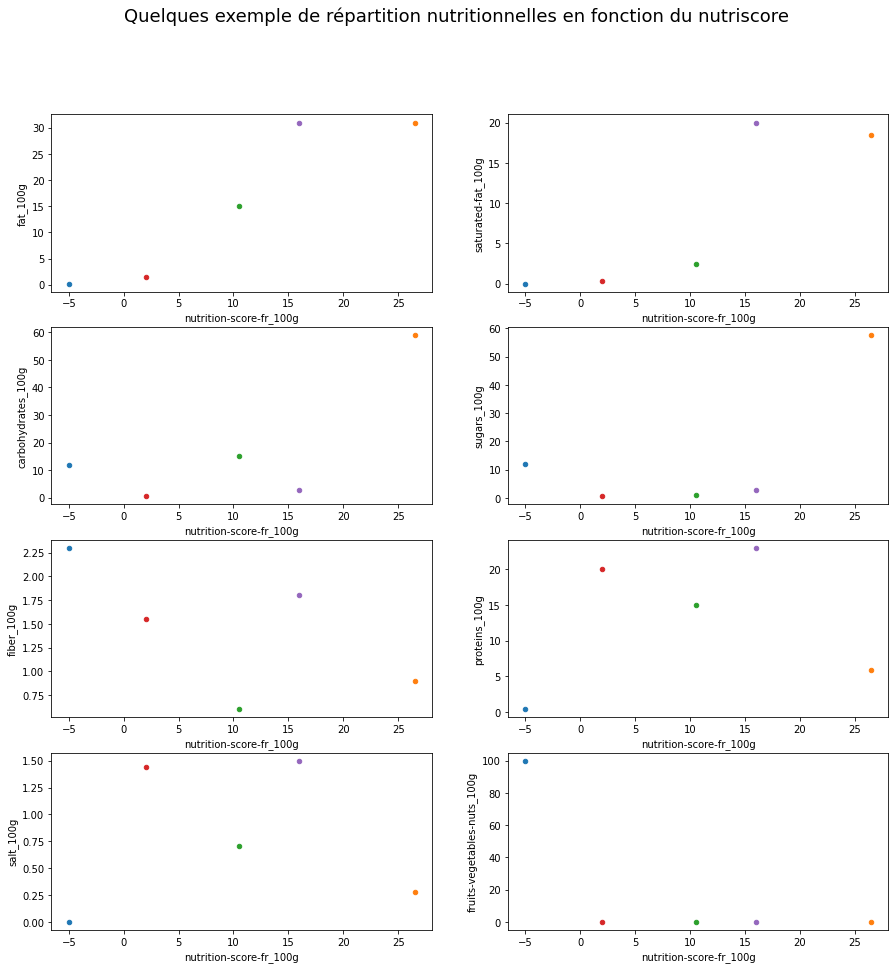

In [30]:
#Nutriscore en fonction des variables nutritionnelles (isolation de quelques points)
fig,axes=plt.subplots(4,2,figsize=(15,15))
n = [rd.randint(0,100000),rd.randint(0,100000),rd.randint(0,100000),rd.randint(0,100000),rd.randint(0,100000)]
print(n)
for i in n:
    axes[0,0].scatter(data_nutrition.at[i,'nutrition-score-fr_100g'],data_nutrition.at[i,"fat_100g"],s=20)
axes[0,0].set_xlabel('nutrition-score-fr_100g')
axes[0,0].set_ylabel("fat_100g")
# axes[0,0].set_xlim([0,100])
# axes[0,0].set_ylim([0,100])

for i in n:
    axes[0,1].scatter(data_nutrition.at[i,'nutrition-score-fr_100g'],data_nutrition.at[i,"saturated-fat_100g"],s=20)
axes[0,1].set_xlabel('nutrition-score-fr_100g')
axes[0,1].set_ylabel("saturated-fat_100g")
# axes[0,0].set_xlim([0,100])
# axes[0,0].set_ylim([0,100])

for i in n:
    axes[1,0].scatter(data_nutrition.at[i,'nutrition-score-fr_100g'],data_nutrition.at[i,'carbohydrates_100g'],s=20)
axes[1,0].set_xlabel('nutrition-score-fr_100g')
axes[1,0].set_ylabel('carbohydrates_100g')
# axes[0,0].set_xlim([0,100])
# axes[0,0].set_ylim([0,100])

for i in n:
    axes[1,1].scatter(data_nutrition.at[i,'nutrition-score-fr_100g'],data_nutrition.at[i,'sugars_100g'],s=20)
axes[1,1].set_xlabel('nutrition-score-fr_100g')
axes[1,1].set_ylabel('sugars_100g')
# axes[0,0].set_xlim([0,100])
# axes[0,0].set_ylim([0,100])

for i in n:
    axes[2,0].scatter(data_nutrition.at[i,'nutrition-score-fr_100g'],data_nutrition.at[i,'fiber_100g'],s=20)
axes[2,0].set_xlabel('nutrition-score-fr_100g')
axes[2,0].set_ylabel('fiber_100g')
# axes[0,0].set_xlim([0,100])
# axes[0,0].set_ylim([0,100])

for i in n:
    axes[2,1].scatter(data_nutrition.at[i,'nutrition-score-fr_100g'],data_nutrition.at[i,'proteins_100g'],s=20)
axes[2,1].set_xlabel('nutrition-score-fr_100g')
axes[2,1].set_ylabel('proteins_100g')
# axes[0,0].set_xlim([0,100])
# axes[0,0].set_ylim([0,100])


for i in n:
    axes[3,0].scatter(data_nutrition.at[i,'nutrition-score-fr_100g'],data_nutrition.at[i,'salt_100g'],s=20)
axes[3,0].set_xlabel('nutrition-score-fr_100g')
axes[3,0].set_ylabel('salt_100g')
# axes[0,0].set_xlim([0,100])
# axes[0,0].set_ylim([0,100])

for i in n:
    axes[3,1].scatter(data_nutrition.at[i,'nutrition-score-fr_100g'],data_nutrition.at[i,'fruits-vegetables-nuts-estimate-from-ingredients_100g'],s=20)
axes[3,1].set_xlabel('nutrition-score-fr_100g')
axes[3,1].set_ylabel('fruits-vegetables-nuts_100g')
# axes[0,0].set_xlim([0,100])
# axes[0,0].set_ylim([0,100])
fig.suptitle('Quelques exemple de répartition nutritionnelles en fonction du nutriscore',size=18)

plt.show()

In [31]:
mean=data_nutrition.apply(lambda r:r.mean()).to_frame(name='MEAN')
mode=data_nutrition.mode().T.rename({0:'MODE'},axis=1)
median=data_nutrition.apply(lambda r:r.median()).to_frame(name='MEDIAN')                                                                     
var=data_nutrition.apply(lambda r:r.var()).to_frame(name='VAR')
std=data_nutrition.apply(lambda r:r.std()).to_frame(name='STD')
skew=data_nutrition.apply(lambda r:r.skew()).to_frame(name='SKEW')
kurt=data_nutrition.apply(lambda r:r.kurtosis()).to_frame(name='KURTOSIS')
pd.concat([mean,mode,median,var,std,skew,kurt],axis=1)

,MEAN,MODE,MEDIAN,VAR,STD,SKEW,KURTOSIS
fat_100g,13.224907,0.0,6.900000,284.087120,16.854884,2.134597,6.152246
saturated-fat_100g,4.987078,0.0,1.700000,59.535272,7.715910,3.389919,21.803998
carbohydrates_100g,27.312617,0.0,14.426538,774.484979,27.829570,0.769083,-0.749037
sugars_100g,13.096072,0.0,3.570000,381.195764,19.524235,1.934505,3.336159
fiber_100g,2.339987,0.0,1.000000,16.654814,4.081031,5.695568,65.208762
proteins_100g,8.790250,0.0,6.000000,100.627719,10.031337,2.545027,11.878125
salt_100g,1.353694,0.0,0.600000,23.584375,4.856375,13.993290,236.992378
sodium_100g,0.551542,0.0,0.240000,4.495577,2.120278,16.719635,399.731581
fruits-vegetables-nuts-estimate-from-ingredients_100g,7.704422,0.0,0.000000,368.016895,19.183766,3.280780,11.038569
nutrition-score-fr_100g,9.022636,0.0,9.000000,74.154847,8.611321,0.139387,-0.946008


Le nutriscore attribue des points négatifs pour favoriser les variables fruits/légumes/noix_100g, fiber_100g et proteins_100g et 
Il attribue des points positifs pour pénaliser les variables gras saturés_100g, sucre_100g et sodium_100g.

## Kurskal - Wallis : pnns_groups_2 et variables nutritionnelles

On réalise un test de Kurskal Wallis entre le pnns_groups_2 et les variables nutritionnelles.

In [39]:
for cat in column_nutrition:
    p=stats.mstats.normaltest(data[cat].dropna()).pvalue
    print(cat,"p = {:e}".format(p),', alpha = 1e-3')

fat_100g p = 0.000000e+00 , alpha = 1e-3
saturated-fat_100g p = 0.000000e+00 , alpha = 1e-3
carbohydrates_100g p = 0.000000e+00 , alpha = 1e-3
sugars_100g p = 0.000000e+00 , alpha = 1e-3
fiber_100g p = 0.000000e+00 , alpha = 1e-3
proteins_100g p = 0.000000e+00 , alpha = 1e-3
salt_100g p = 0.000000e+00 , alpha = 1e-3
sodium_100g p = 0.000000e+00 , alpha = 1e-3
fruits-vegetables-nuts-estimate-from-ingredients_100g p = 0.000000e+00 , alpha = 1e-3
nutrition-score-fr_100g p = 0.000000e+00 , alpha = 1e-3
energy_kcal_100g p = 0.000000e+00 , alpha = 1e-3


In [40]:
normal_test=pd.DataFrame()
normal_test.index=['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'fruits-vegetables-nuts_100g']
normal_test['pvalue']=["{:e}".format(stats.mstats.normaltest(data['fat_100g'].dropna()).pvalue),"{:e}".format(stats.mstats.normaltest(data['saturated-fat_100g'].dropna()).pvalue),"{:e}".format(stats.mstats.normaltest(data['carbohydrates_100g'].dropna()).pvalue),"{:e}".format(stats.mstats.normaltest(data['sugars_100g'].dropna()).pvalue),"{:e}".format(stats.mstats.normaltest(data['fiber_100g'].dropna()).pvalue),"{:e}".format(stats.mstats.normaltest(data['proteins_100g'].dropna()).pvalue),"{:e}".format(stats.mstats.normaltest(data['salt_100g'].dropna()).pvalue),"{:e}".format(stats.mstats.normaltest(data['sodium_100g'].dropna()).pvalue),"{:e}".format(stats.mstats.normaltest(data['fruits-vegetables-nuts-estimate-from-ingredients_100g'].dropna()).pvalue)]
normal_test

,pvalue
fat_100g,0.000000e+00
saturated-fat_100g,0.000000e+00
carbohydrates_100g,0.000000e+00
sugars_100g,0.000000e+00
fiber_100g,0.000000e+00
proteins_100g,0.000000e+00
salt_100g,0.000000e+00
sodium_100g,0.000000e+00
fruits-vegetables-nuts_100g,0.000000e+00


In [41]:
from scipy import stats
def kruskal_pnns(X):
    sous_ech=[list(data_nutrition[data['pnns_groups_2']=='unknown'][X].values)]
    for cat in data['pnns_groups_2'].unique():
        sous_ech.append(list(data_nutrition[data['pnns_groups_2']==cat][X].values)) 
    pvalue=stats.kruskal(sous_ech[0],sous_ech[1],sous_ech[2],sous_ech[3],sous_ech[4],sous_ech[5],sous_ech[6],sous_ech[7],sous_ech[8],
                        sous_ech[9],sous_ech[10],sous_ech[11],sous_ech[12],sous_ech[13],sous_ech[14],sous_ech[15],sous_ech[16],
                        sous_ech[17],sous_ech[18],sous_ech[19],sous_ech[20],sous_ech[21],sous_ech[22],sous_ech[23],sous_ech[24],
                        sous_ech[25],sous_ech[26],sous_ech[27],sous_ech[28],sous_ech[29],sous_ech[30],sous_ech[31],sous_ech[32],
                        sous_ech[33],sous_ech[34],sous_ech[35],sous_ech[36], sous_ech[37],sous_ech[38],sous_ech[39],sous_ech[40],
                        nan_policy='omit').pvalue
    stat=stats.kruskal(sous_ech[0],sous_ech[1],sous_ech[2],sous_ech[3],sous_ech[4],sous_ech[5],sous_ech[6],sous_ech[7],sous_ech[8],
                        sous_ech[9],sous_ech[10],sous_ech[11],sous_ech[12],sous_ech[13],sous_ech[14],sous_ech[15],sous_ech[16],
                        sous_ech[17],sous_ech[18],sous_ech[19],sous_ech[20],sous_ech[21],sous_ech[22],sous_ech[23],sous_ech[24],
                        sous_ech[25],sous_ech[26],sous_ech[27],sous_ech[28],sous_ech[29],sous_ech[30],sous_ech[31],sous_ech[32],
                        sous_ech[33],sous_ech[34],sous_ech[35],sous_ech[36], sous_ech[37],sous_ech[38],sous_ech[39],sous_ech[40],
                        nan_policy='omit').statistic
    return ('pvalue:',"{:e}".format(pvalue),'stat:',stat)

In [42]:
kurskal=pd.DataFrame()
kurskal.index=['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'fruits-vegetables-nuts_100g']
kurskal['pvalue']=[kruskal_pnns('fat_100g')[1],kruskal_pnns('saturated-fat_100g')[1],kruskal_pnns('carbohydrates_100g')[1],kruskal_pnns('sugars_100g')[1],kruskal_pnns('fiber_100g')[1],kruskal_pnns('proteins_100g')[1],kruskal_pnns('salt_100g')[1],kruskal_pnns('sodium_100g')[1],kruskal_pnns('fruits-vegetables-nuts-estimate-from-ingredients_100g')[1]]
kurskal['stat']=[kruskal_pnns('fat_100g')[3],kruskal_pnns('saturated-fat_100g')[3],kruskal_pnns('carbohydrates_100g')[3],kruskal_pnns('sugars_100g')[3],kruskal_pnns('fiber_100g')[3],kruskal_pnns('proteins_100g')[3],kruskal_pnns('salt_100g')[3],kruskal_pnns('sodium_100g')[3],kruskal_pnns('fruits-vegetables-nuts-estimate-from-ingredients_100g')[3]]
kurskal

,pvalue,stat
fat_100g,0.000000e+00,26698.098615
saturated-fat_100g,0.000000e+00,26996.125581
carbohydrates_100g,0.000000e+00,37420.043468
sugars_100g,0.000000e+00,30494.395932
fiber_100g,0.000000e+00,21823.195932
proteins_100g,0.000000e+00,33257.335335
salt_100g,0.000000e+00,27075.877724
sodium_100g,0.000000e+00,27062.245879
fruits-vegetables-nuts_100g,0.000000e+00,11334.537089


In [101]:
# X = "pnns_groups_2" # qualitative
# Y = "fat_100g" # quantitative

# sous_echantillon = data # On ne garde que les dépenses

# def eta_squared(x,y):
#     moyenne_y = y.mean()
#     classes = []
#     for classe in x.unique():
#         yi_classe = y[x==classe]
#         classes.append({'ni': len(yi_classe),
#                         'moyenne_classe': yi_classe.mean()})
#     SCT = sum([(yj-moyenne_y)**2 for yj in y])
#     SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
#     return SCE/SCT
# ANOVA=pd.DataFrame()
# ANOVA.index=['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g','sodium_100g','fruits-vegetables-nuts_100g','energy_kcal_100g','nutrition-score_fr_100g']  
# ANOVA['eta_squared']=[eta_squared(sous_echantillon[X],sous_echantillon["fat_100g"]),eta_squared(data[X],sous_echantillon["saturated-fat_100g"]),eta_squared(data[X],sous_echantillon["carbohydrates_100g"]),eta_squared(data[X],sous_echantillon["sugars_100g"]),eta_squared(data[X],sous_echantillon["fiber_100g"]),eta_squared(data[X],sous_echantillon["proteins_100g"]),eta_squared(data[X],sous_echantillon["salt_100g"]),eta_squared(data[X],sous_echantillon["sodium_100g"]),eta_squared(data[X],sous_echantillon["fruits-vegetables-nuts-estimate-from-ingredients_100g"]),eta_squared(data[X],sous_echantillon["energy_kcal_100g"]),eta_squared(sous_echantillon[X],sous_echantillon['nutrition-score-fr_100g'])]
# ANOVA

## Kurskal - Wallis : nutriscore_grade et variables nutritionnelles

On réalise un test de Kurskal Wallis entre le nutriscore_grade et les variables nutritionnelles.

In [43]:
def kruskal_nutriscore(X):
    sous_ech=[list(data_nutrition[(data['nutriscore_grade'].fillna('unknown'))=='unknown'][X].values)]
    for cat in data['pnns_groups_2'].unique():
        sous_ech.append(list(data_nutrition[data['pnns_groups_2'].fillna('unknown')==cat][X].values)) 
    pvalue=stats.kruskal(sous_ech[0],sous_ech[1],sous_ech[2],sous_ech[3],sous_ech[4],sous_ech[5],
                        nan_policy='omit').pvalue
    stat=stats.kruskal(sous_ech[0],sous_ech[1],sous_ech[2],sous_ech[3],sous_ech[4],sous_ech[5],
                        nan_policy='omit').statistic
    return ('pvalue:',"{:e}".format(pvalue),'stat:',stat)

In [44]:
kurskal=pd.DataFrame()
kurskal.index=['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'fruits-vegetables-nuts_100g']
kurskal['pvalue']=[kruskal_nutriscore('fat_100g')[1],kruskal_nutriscore('saturated-fat_100g')[1],kruskal_nutriscore('carbohydrates_100g')[1],kruskal_nutriscore('sugars_100g')[1],kruskal_nutriscore('fiber_100g')[1],kruskal_nutriscore('proteins_100g')[1],kruskal_nutriscore('salt_100g')[1],kruskal_nutriscore('sodium_100g')[1],kruskal_nutriscore('fruits-vegetables-nuts-estimate-from-ingredients_100g')[1]]
kurskal['stat']=[kruskal_nutriscore('fat_100g')[3],kruskal_nutriscore('saturated-fat_100g')[3],kruskal_nutriscore('carbohydrates_100g')[3],kruskal_nutriscore('sugars_100g')[3],kruskal_nutriscore('fiber_100g')[3],kruskal_nutriscore('proteins_100g')[3],kruskal_nutriscore('salt_100g')[3],kruskal_nutriscore('sodium_100g')[3],kruskal_nutriscore('fruits-vegetables-nuts-estimate-from-ingredients_100g')[3]]
kurskal

,pvalue,stat
fat_100g,0.000000e+00,4489.773397
saturated-fat_100g,0.000000e+00,3594.968553
carbohydrates_100g,1.762413e-150,706.683586
sugars_100g,2.998188e-261,1218.425462
fiber_100g,2.041335e-298,1389.980149
proteins_100g,0.000000e+00,2886.924068
salt_100g,0.000000e+00,2251.629582
sodium_100g,0.000000e+00,2250.289163
fruits-vegetables-nuts_100g,0.000000e+00,3776.634116


In [102]:
# X = "nutriscore_grade" # qualitative
# Y = "fat_100g" # quantitative

# sous_echantillon = data[~data["nutriscore_grade"].isna()] # On ne garde que les dépenses

# def eta_squared(x,y):
#     moyenne_y = y.mean()
#     classes = []
#     for classe in x.unique():
#         yi_classe = y[x==classe]
#         classes.append({'ni': len(yi_classe),
#                         'moyenne_classe': yi_classe.mean()})
#     SCT = sum([(yj-moyenne_y)**2 for yj in y])
#     SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
#     return SCE/SCT
# ANOVA=pd.DataFrame()
# ANOVA.index=['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g','sodium_100g','fruits-vegetables-nuts_100g','energy_kcal_100g','nutrition-score_fr_100g']  
# ANOVA['eta_squared']=[eta_squared(sous_echantillon[X],sous_echantillon["fat_100g"]),eta_squared(sous_echantillon[X],sous_echantillon["saturated-fat_100g"]),eta_squared(sous_echantillon[X],sous_echantillon["carbohydrates_100g"]),eta_squared(sous_echantillon[X],sous_echantillon["sugars_100g"]),eta_squared(sous_echantillon[X],sous_echantillon["fiber_100g"]),eta_squared(sous_echantillon[X],sous_echantillon["proteins_100g"]),eta_squared(sous_echantillon[X],sous_echantillon["salt_100g"]),eta_squared(sous_echantillon[X],sous_echantillon["sodium_100g"]),eta_squared(sous_echantillon[X],sous_echantillon["fruits-vegetables-nuts-estimate-from-ingredients_100g"]),eta_squared(sous_echantillon[X],sous_echantillon["energy_kcal_100g"]),eta_squared(sous_echantillon[X],sous_echantillon['nutrition-score-fr_100g'])]
# ANOVA

# <p style='text-align:center;' >Analyse du Xi-2 du nutriscore et du nova_group</p>

On va représenter le tableau de contingence du nutriscore et du nova_group.

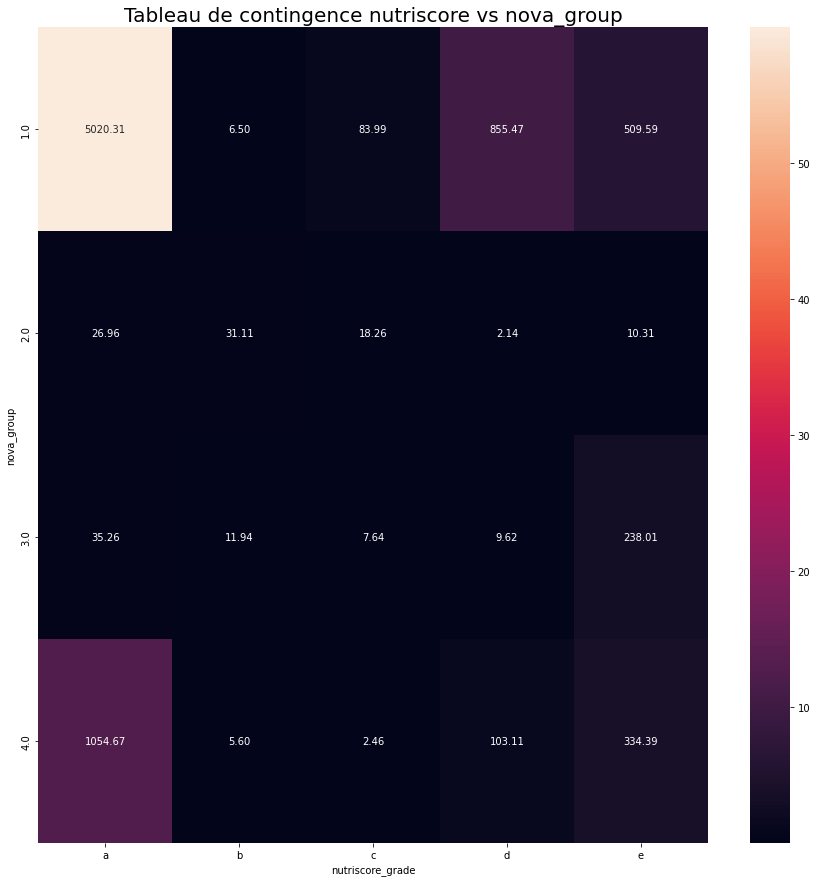

In [45]:
X = "nova_group"
Y = "nutriscore_grade"

cont = data[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
f,ax=plt.subplots(figsize=(15,15))
tx = cont.loc[:,["Total"]]
ty = cont.loc[["Total"],:]
n = len(data[[X,Y]].dropna())
indep = tx.dot(ty) / n

c = cont.fillna(0) # On remplace les valeurs nulles par 0
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = 100*measure/xi_n
sns.heatmap(table.iloc[:-1,:-1],annot=measure.iloc[:-1,:-1],fmt='.2f')
ax.set_title('Tableau de contingence nutriscore vs nova_group',fontsize=20)
plt.show()

On observe globalement des valeurs plutôt basse ce qui suggère l’indépendance des deux variables. 
Les produits du groupe nova 1 et ayant un nutriscore A contribue peu à l’indépendance des deux variables (cela laisse penser que les produits non transformé ont de grande change d’avoir un nutriscore A.
Le nutriscore est donc globalement indépendant du degré de transformation des produits.

# <p style='text-align:center;' >Analyse des Composantes Principales (ACP)</p>

Le PCA sert à faire de la réduction de dimensionnalité en conservant un maximum d’information sur la variance des données.
Cela permet par exemple de représenter un jeu de données multidimensionnel dans un plan à deux dimensions. 
On réalise un PCA sur les variables nutritionnelles et on trace l’histogramme de gauche qu’on appelle l’éboulis des valeurs propres.

In [46]:
n_comp=8
pca = decomposition.PCA(n_components=n_comp)
pca.fit(data_nutrition[column_nutrition[:-2]])

PCA(n_components=8)

In [47]:
pct_var_expl=[100*x for x in pca.explained_variance_ratio_]

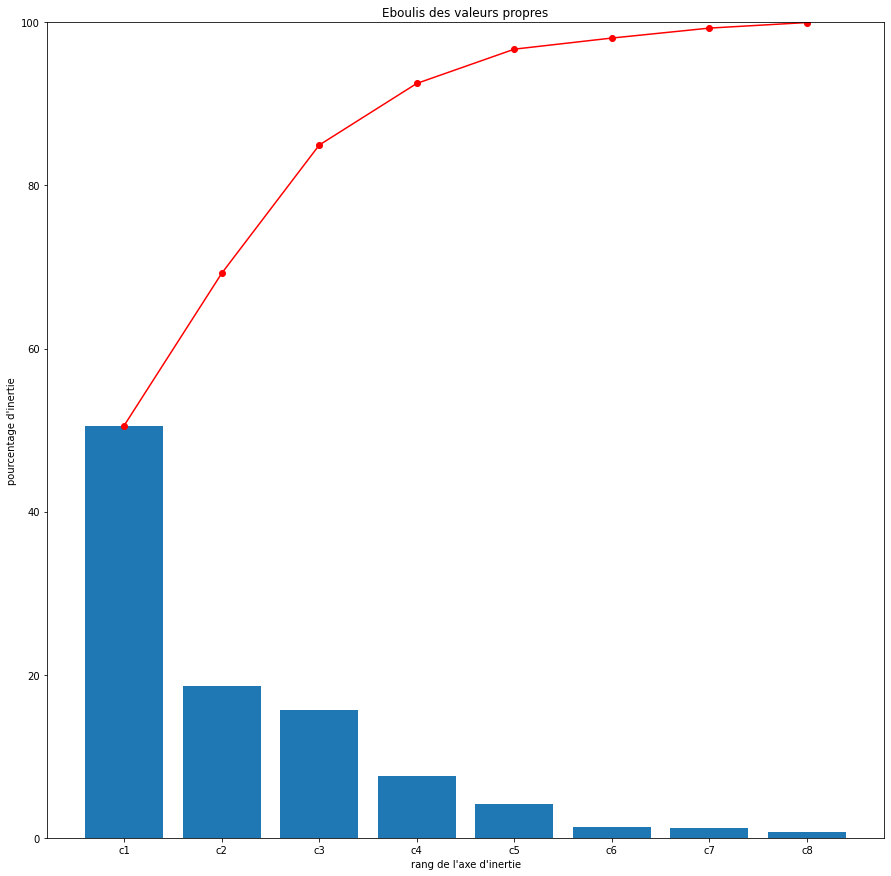

In [48]:
plt.subplots(figsize=(15,15))
plt.bar(height=pct_var_expl,x=['c'+str(i+1) for i in range(len(pct_var_expl))])
plt.plot(np.arange(len(pct_var_expl)), np.cumsum(pct_var_expl),c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.ylim([0, 100])
plt.show()

On représente ensuite les données nutritionnelles d’un échantillons de produit dans le plans 2D des composantes principales de l’ACP.

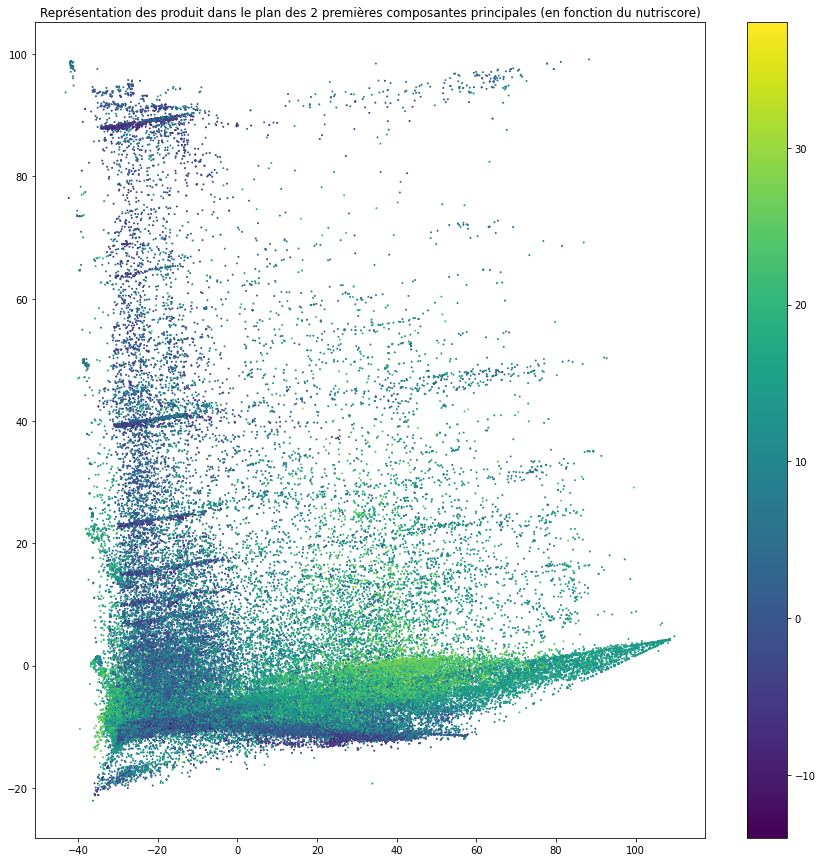

In [49]:
X_projected = pca.transform(data_nutrition[column_nutrition[:-2]])
fig,ax=plt.subplots(figsize=(15,15))
plt.scatter(X_projected[:, 0], X_projected[:, 1],s=1,c=data_nutrition['nutrition-score-fr_100g'].values)
plt.colorbar()
ax.set_title('Représentation des produit dans le plan des 2 premières composantes principales (en fonction du nutriscore)')
plt.show()

L’échelle de couleur correspond au nutriscore de chaque produit
Ce type de graphique permet de se représenter des données multidimensionnelles et peut servir à identifier des clusters par exemple.